In [1]:
import os
# Display current working directory
print(os.getcwd())
# To make sure opencv imports .exr files
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
# If the current directory is not WDSS, then set it to one level up
if os.getcwd()[-4:] != 'WDSS':
    os.chdir('..')
print(os.getcwd())

c:\Dev\MinorProject\WDSS\jupyter_notebooks
c:\Dev\MinorProject\WDSS


In [2]:
import torch

from config import Settings, device
from commons import initialize
from utils.image_utils import ImageUtils
from network.losses import ImageEvaluator
from utils.brdf import BRDFProcessor
from utils.tonemap import BaseTonemapper

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


c:\Dev\MinorProject\WDSS\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Dev\MinorProject\WDSS\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Dev\MinorProject\WDSS\.venv\Lib\site-packages\lpips\weights\v0.1\vgg.pth


c:\Dev\MinorProject\WDSS\.venv\Lib\site-packages\lpips\lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='

In [3]:
def normalize_hdr(hdr_image):
    return 1.0 - torch.exp(-hdr_image)

def denomalize_hdr(hdr_image):
    return -torch.log(1.0 - hdr_image)

def brdf_demodulate(
    frame: torch.Tensor,
    brdf_map: torch.Tensor
) -> torch.Tensor:
    """Demodulate the frame using the BRDF map.
    """
    # return frame / brdf_map

    demodulated_frame = torch.where(brdf_map < 0.001, 0, frame / brdf_map)

    return demodulated_frame

def brdf_remodulate(
    frame: torch.Tensor,
    brdf_map: torch.Tensor
) -> torch.Tensor:
    """Remodulate the frame using the BRDF map.
    """
    # return frame * brdf_map

    remodulated_frame = torch.where(brdf_map < 0.001, 0, frame * brdf_map)

    return remodulated_frame

In [4]:
settings = Settings('config/config.json', 'TEST')
initialize(settings)

Job: Navin_relu_mse, Model: TEST, Device: cuda
Model path: out\Navin_relu_mse-TEST\model
Log path: out\Navin_relu_mse-TEST\logs


In [5]:
from network.dataset import *

# Load the dataset
train, val, test = WDSSDatasetCompressed.get_datasets(settings)

In [6]:
frame_no = 45
raw_frames = test._get_raw_frames(frame_no)

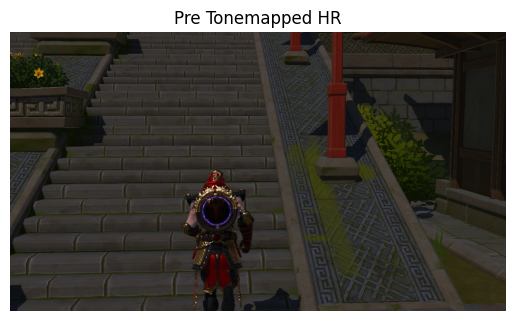

Normal: max: 15.7265625, min: 0.0
Normalized: max: 0.9999998807907104, min: 0.0
Denormalized: max: 15.942384719848633, min: -0.0
MSE: 1.6925984169802177e-08


In [7]:
pre_tonemapped_hr = raw_frames[RawFrameGroup.HR_GB][GB_Type.PRE_TONEMAPPED]

tonemap_normalization_factor = 2.0
pre_tonemapped_hr_normalized = normalize_hdr(pre_tonemapped_hr)

pre_tonemapped_denormalized = denomalize_hdr(pre_tonemapped_hr_normalized)

ImageUtils.display_image(pre_tonemapped_hr_normalized, 'Pre Tonemapped HR')
print(f'Normal: max: {pre_tonemapped_hr.max()}, min: {pre_tonemapped_hr.min()}')
print(f'Normalized: max: {pre_tonemapped_hr_normalized.max()}, min: {pre_tonemapped_hr_normalized.min()}')
print(f'Denormalized: max: {pre_tonemapped_denormalized.max()}, min: {pre_tonemapped_denormalized.min()}')

mse = ImageEvaluator.mse(pre_tonemapped_hr, pre_tonemapped_denormalized)
print(f'MSE: {mse}')


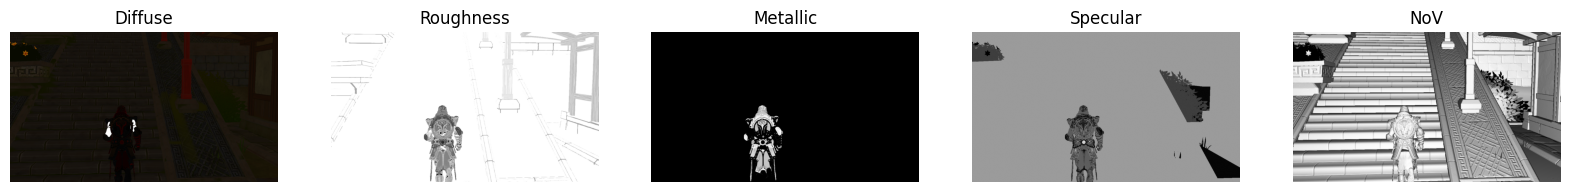

In [8]:
diffuse = raw_frames[RawFrameGroup.HR_GB][GB_Type.DIFFUSE_COLOR]
base_color = raw_frames[RawFrameGroup.HR_GB][GB_Type.BASE_COLOR]
metallic = raw_frames[RawFrameGroup.HR_GB][GB_Type.METALLIC_ROUGHNESS_SPECULAR][0:1, :, :]

roughness = raw_frames[RawFrameGroup.HR_GB][GB_Type.METALLIC_ROUGHNESS_SPECULAR][1:2, :, :]
specular = raw_frames[RawFrameGroup.HR_GB][GB_Type.METALLIC_ROUGHNESS_SPECULAR][2:3, :, :]
NoV = raw_frames[RawFrameGroup.HR_GB][GB_Type.NoV_Depth][0:1, :, :]

ImageUtils.display_images([diffuse, roughness, metallic, specular, NoV], ['Diffuse', 'Roughness', 'Metallic', 'Specular', 'NoV'])

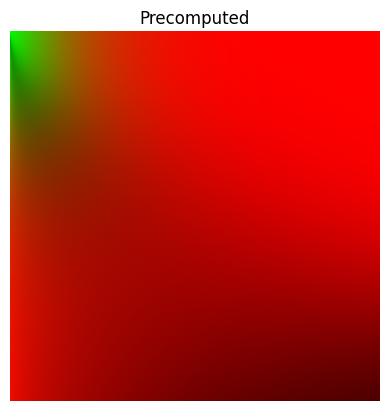

In [9]:
precomp = ImageUtils.opencv_image_to_tensor(ImageUtils.load_exr_image_opencv('res/Precomputed.exr')).squeeze(0)

ImageUtils.display_image(precomp, 'Precomputed')

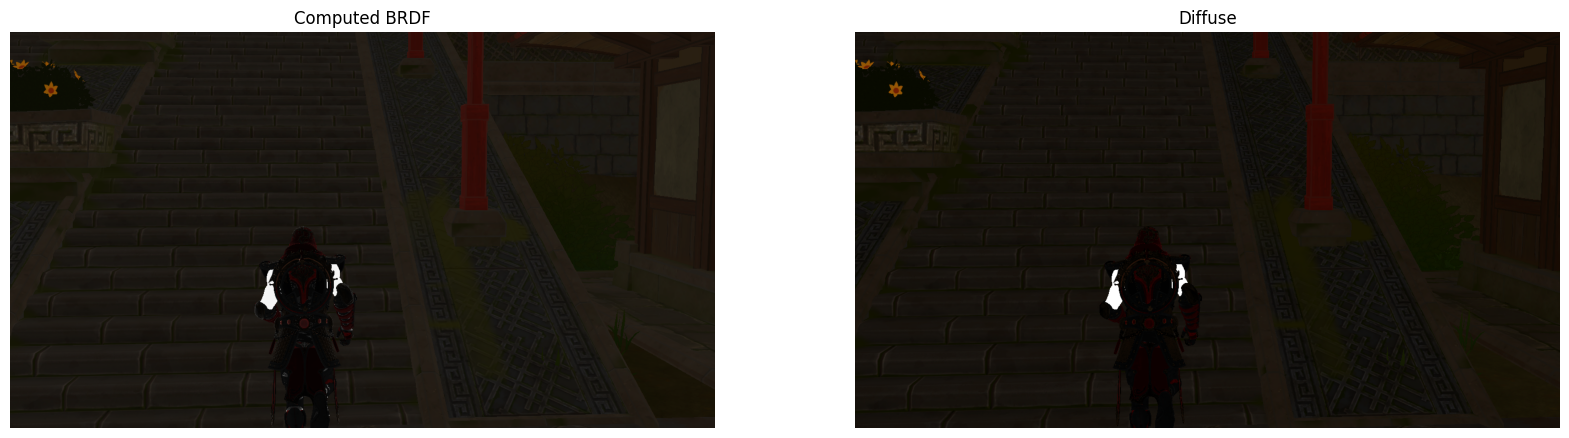

Computed BRDF: max: 1.0498775243759155, min: 4.021319909952581e-05
Diffuse: max: 1.0, min: 0.0


In [10]:
computed_brdf = BRDFProcessor.compute_brdf(diffuse, roughness, metallic, specular, NoV, precomp, 511)
# Normalize the computed BRDF
# computed_brdf = normalize_hdr(computed_brdf)

ImageUtils.display_images([computed_brdf, diffuse], ['Computed BRDF', 'Diffuse'])
print(f'Computed BRDF: max: {computed_brdf.max()}, min: {computed_brdf.min()}')
print(f'Diffuse: max: {diffuse.max()}, min: {diffuse.min()}')

In [11]:
frame_to_demodulate = pre_tonemapped_hr

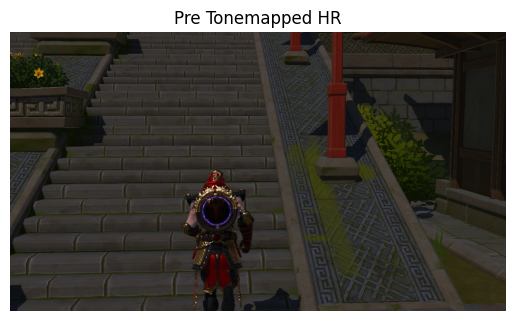

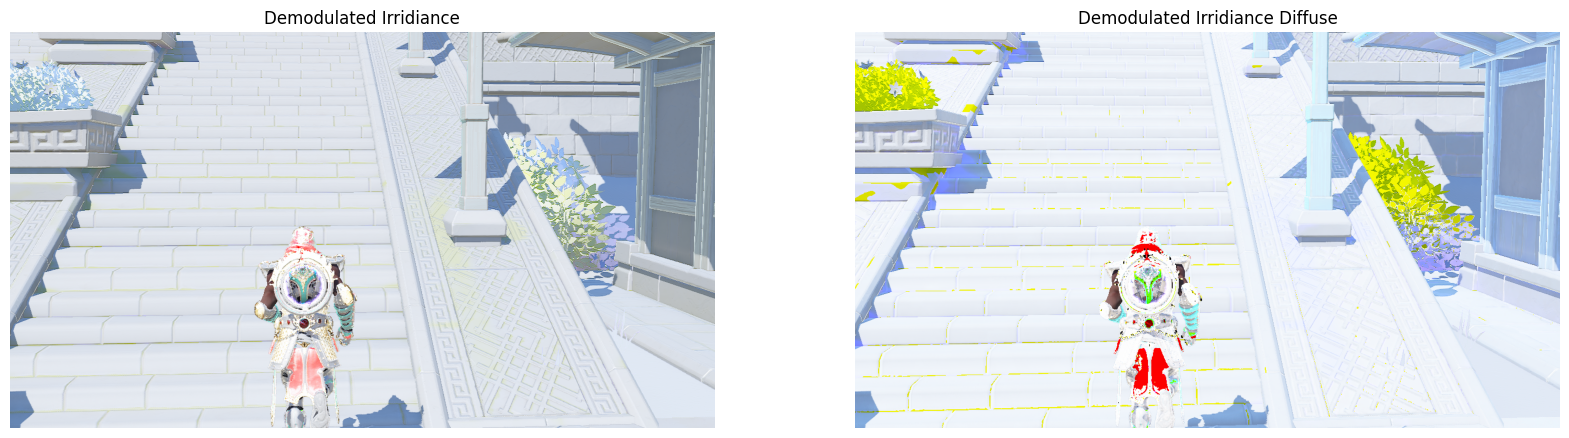

Demodulated Irridiance: max: 1124.3372802734375, min: 0.0
Demodulated Irridiance Diffuse: max: 4724.9736328125, min: 0.0


In [12]:
demodulated_irridiance = brdf_demodulate(frame_to_demodulate, computed_brdf)
demodulated_irridiance_diffuse = brdf_demodulate(frame_to_demodulate, diffuse)

ImageUtils.display_image(pre_tonemapped_hr_normalized, 'Pre Tonemapped HR')
ImageUtils.display_images([normalize_hdr(demodulated_irridiance), normalize_hdr(demodulated_irridiance_diffuse)], ['Demodulated Irridiance', 'Demodulated Irridiance Diffuse'])
print(f'Demodulated Irridiance: max: {demodulated_irridiance.max()}, min: {demodulated_irridiance.min()}')
print(f'Demodulated Irridiance Diffuse: max: {demodulated_irridiance_diffuse.max()}, min: {demodulated_irridiance_diffuse.min()}')

In [13]:
normalization_factor = 200.0

demodulated_irridiance_normalized = normalize_hdr(demodulated_irridiance / normalization_factor)
demodulated_irridiance_denormalized = denomalize_hdr(demodulated_irridiance_normalized) * normalization_factor

mse = ImageEvaluator.mse(pre_tonemapped_hr, demodulated_irridiance_denormalized)
print(f'MSE: {mse}')
print(f'Demodulated Irridiance Normalized: max: {demodulated_irridiance_normalized.max()}, min: {demodulated_irridiance_normalized.min()}')
print(f'Demodulated Irridiance Denormalized: max: {demodulated_irridiance_denormalized.max()}, min: {demodulated_irridiance_denormalized.min()}')

MSE: 27.014328002929688
Demodulated Irridiance Normalized: max: 0.9963814616203308, min: 0.0
Demodulated Irridiance Denormalized: max: 1124.3370361328125, min: -0.0


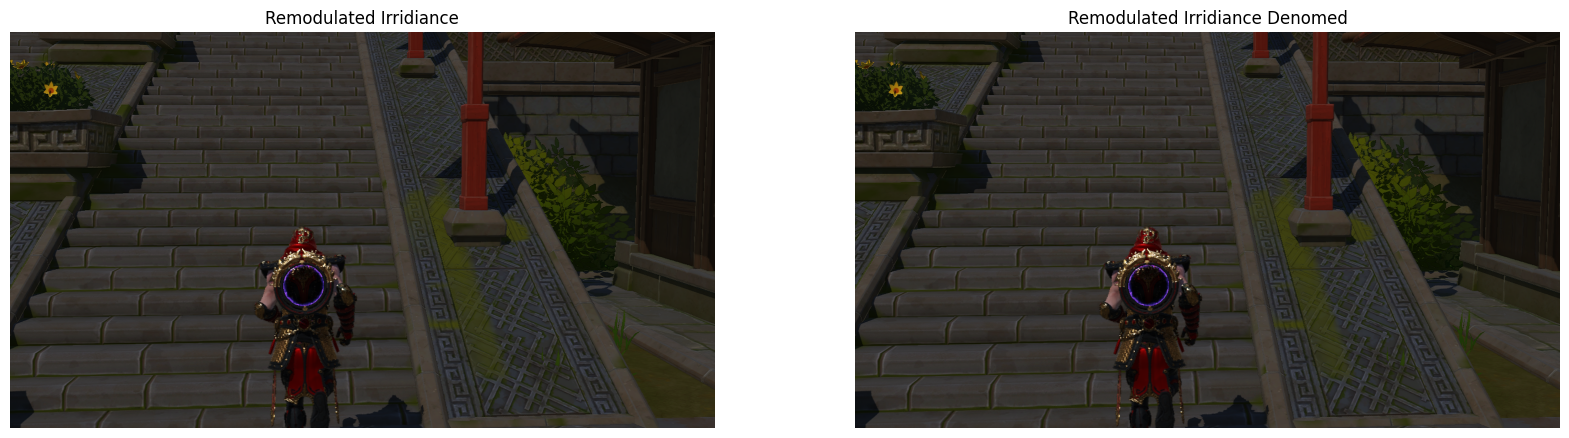

In [14]:
# Remodulate the demodulated irridiance
remodulated_irridiance = brdf_remodulate(demodulated_irridiance, computed_brdf)
remodulated_irridiance_demoned = brdf_remodulate(demodulated_irridiance_denormalized, computed_brdf)

ImageUtils.display_images([normalize_hdr(remodulated_irridiance), normalize_hdr(remodulated_irridiance_demoned)], ['Remodulated Irridiance', 'Remodulated Irridiance Denomed'])

In [15]:
# Compute losses
mse = ImageEvaluator.mse(frame_to_demodulate, remodulated_irridiance)
mse_demoned = ImageEvaluator.mse(frame_to_demodulate, remodulated_irridiance_demoned)

print(f'MSE: {mse}')
print(f'MSE Demoned: {mse_demoned}')

MSE: 5.644109023705823e-06
MSE Demoned: 5.644109023705823e-06


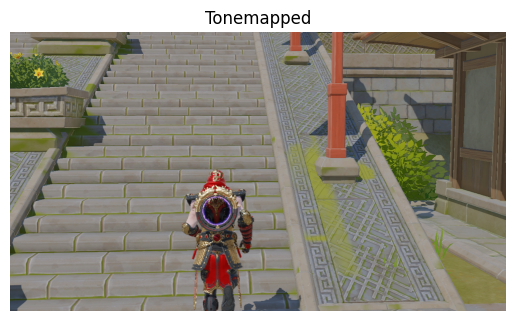

In [22]:
from utils.tonemap import BaseTonemapper

tonemapper = BaseTonemapper.from_name('Reinhard-5')
tonemapped = tonemapper.forward(remodulated_irridiance)

ImageUtils.display_image(tonemapped, 'Tonemapped')